In [1]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

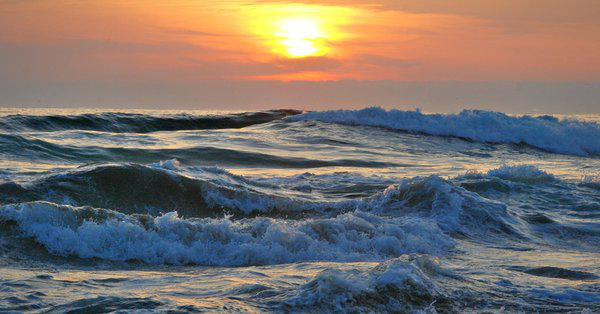

In [2]:
Image.open('im.jpg')

In [3]:
%%writefile task_08_shift_im_mpi.py

import os
import time
import numpy as np
import tracemalloc

from PIL import Image
from mpi4py import MPI

tracemalloc.start()

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

IS_ROOT = rank == 0
IS_SAVE = False

H = 798
W = 1200
numDataPerRank = H // size

data = None

if IS_ROOT:
    data = np.array(Image.open('im2.jpg'))
    numDataPerRank =  H - (numDataPerRank * (size - 1))

if IS_SAVE:
    os.makedirs('images', exist_ok=True)

received = np.empty((numDataPerRank, W, 3), dtype=np.uint8)
sendcounts = np.array(comm.gather(received.size, 0))

def roll(arr):
    res = np.empty_like(arr)
    w = arr.shape[1]
    for i in range(w):
        res[:, (i + 1) % w] = arr[:, i]
    return res
    
for i in range(W):
    comm.Scatterv((data, sendcounts), received, root=0)
    received_rolled = roll(received)
    comm.Gatherv(received_rolled, (data, sendcounts), root=0)
    if IS_ROOT and IS_SAVE:
        Image.fromarray(data).save(f'images/{i:0>5d}.jpg')


current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

peak = np.array(comm.gather(peak, 0))
if IS_ROOT:
    print(size)
    print(np.sum(peak / 1024 / 1024))

Overwriting task_08_shift_im_mpi.py


In [4]:
!mpirun -n 10 --allow-run-as-root --mca btl ^vader python3 task_08_shift_im_mpi.py
print('MPI done')


files = [f for f in os.listdir('images') if os.path.isfile(os.path.join('images', f))]
files.sort()
images = [Image.open('images/' + f) for f in files]

imageio.mimsave('shift.gif', images, fps=200)

!rm -r images

![Gif](shift.gif)

In [5]:
time_arr = []
processes = range(1, 12)
for i in processes:
    print(f'Num of processes: {i},\t', end='')
    t = %timeit -o -r 3 !mpirun -n {i} --allow-run-as-root --mca btl ^vader python3 task_08_shift_im_mpi.py 1>>log.log
    time_arr.append(t.best)

Num of processes: 1,	9.61 s ± 24.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 2,	6.84 s ± 44.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 3,	6.26 s ± 42.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 4,	5.82 s ± 37 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 5,	5.68 s ± 53.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 6,	5.5 s ± 55.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 7,	5.42 s ± 111 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 8,	5.33 s ± 47.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 9,	5.37 s ± 49.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 10,	5.32 s ± 72 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 11,	5.37 s ± 31 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Text(0.5, 0.98, 'SpeedUp vs Num of processes')

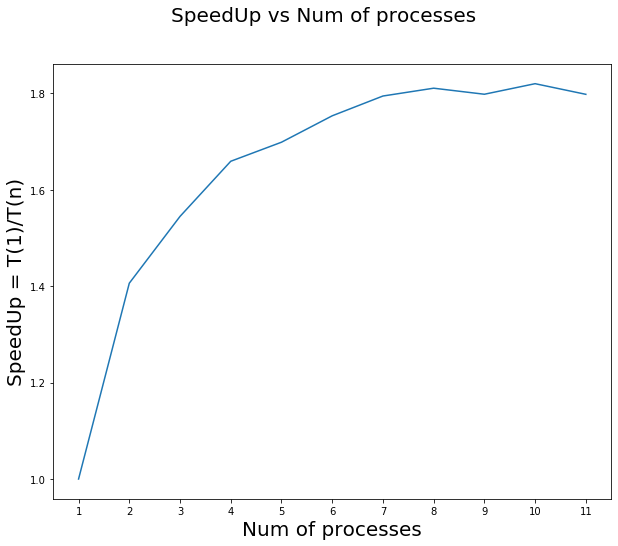

In [6]:
speedup = time_arr[0] / np.array(time_arr)

plt.figure(figsize=(10, 8))
plt.plot(processes, speedup)
plt.xticks(processes)
plt.xlabel('Num of processes', fontsize=20)
plt.ylabel('SpeedUp = T(1)/T(n)', fontsize=20)
plt.suptitle('SpeedUp vs Num of processes', fontsize=20)

In [7]:
with open('log.log', 'r') as log:
    data = log.readlines()
data = np.array(data)
x = data[::2][::4].astype(int)
y = data[1::2][::4].astype(float)
!rm log.log

Text(0.5, 0.98, 'Memory vs Num of processes')

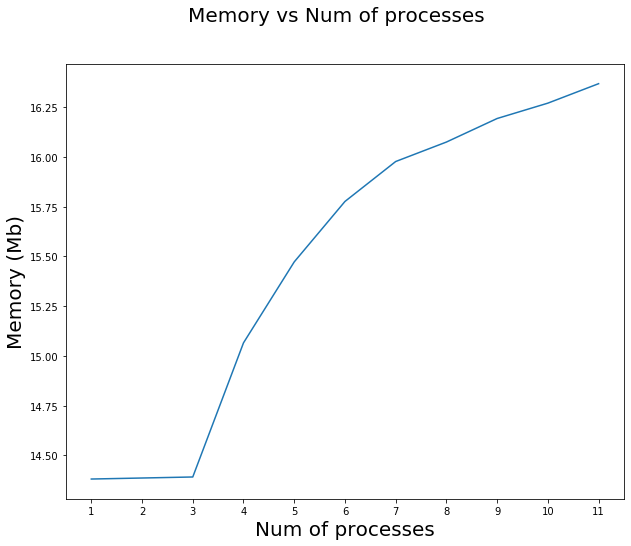

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(x, y)
plt.xticks(x)
plt.xlabel('Num of processes', fontsize=20)
plt.ylabel('Memory (Mb)', fontsize=20)
plt.suptitle('Memory vs Num of processes', fontsize=20)